
<a id='chap-tpreseauxneuronesmulticouches1'></a>

# Travaux pratiques - Réseaux de neurones multicouches (1)

(correspond à 1 séance de TP)

Références externes utiles :

> - [Documentation NumPy](https://docs.scipy.org/doc/numpy/user/index.html)  
- [Documentation SciPy](https://docs.scipy.org/doc/scipy/reference/)  
- [Documentation MatPlotLib](http://matplotlib.org/)  
- [Site scikit-learn](http://scikit-learn.org/stable/index.html)  
- [Site langage python](https://www.python.org)  



**L’objectif** de cette séance de TP est d’illustrer le fonctionnement des perceptrons multi-couches pour un problème de classification et d’explorer l’impact des fonctions d’activation des neurones de la couche cachée, du nombre de neurones cachés et du nombre de couches cachées.

## Préparation des données

Les données employées sont constituées d’un bien connu [ensemble de 150 observations de fleurs d’iris](https://archive.ics.uci.edu/ml/datasets/iris). Pour chaque observation sont disponibles la longueur et la largeur des sépales (en cm), la longueur et la largeur des pétales (en cm), ainsi que la variété d’iris (Iris Setosa, Iris Versicolo(u)r, Iris Virginica). L’objectif est de prédire la classe (la variable expliquée, ici la variété) à partir des quatre variables explicatives (longuers et largeurs des sépales et des pétales).

Dans Scikit-learn nous pouvons trouver [les données Iris déjà présentes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) et nous pouvons les charger directement avec

In [ ]:
# importation bibliothèque numpy
import numpy as np
# importation fonction chargement données iris
from sklearn.datasets import load_iris
donnees = load_iris()
# affichage 3 premières observations
donnees.data[0:3,:]
# dimensions matrice observations
donnees.data.shape
# affichage étiquettes classe 3 premières observations
donnees.target[0:3]
# dimensions vecteur étiquettes de classe
donnees.target.shape

(150,)

Ou alors, pour illustrer un cas plus général, télécharger directement à partir du site le fichier de données (en format CSV)

In [ ]:
%%bash
wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2023-03-27 00:16:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data’

     0K ....                                                  100% 85.7M=0s

2023-03-27 00:16:18 (85.7 MB/s) - ‘iris.data’ saved [4551/4551]



et en lire les valeurs des quatre variables explicatives

In [ ]:
# valeurs séparées par virgule, colonnes 0 à 3, y compris 1ère ligne
data = np.loadtxt('iris.data', delimiter=',', usecols=[0,1,2,3], skiprows=0)

Les étiquettes étant sous forme textuelle dans le fichier `iris.data` (c’est à dire `Iris-setosa`, `Iris-versicolor` et respectivement `Iris-virginica`) nous tirons profit du fait que ces trois classes se succèdent dans le fichier de données et qu’il y a exactement 50 observations par classe pour générer directement des étiquettes de classe. Nous chercherons d’abord à construire des modèles permettant de séparer les iris en **deux** classes, Iris-setosa et les autres (Iris-versicolor et Iris-virginica). Nous utilisons alors une étiquette 1 pour Iris-setosa et une étiquette 0 pour les autres :

In [ ]:
# générer étiquettes de classe
l1c = np.ones(50, dtype=int)
l2c = np.zeros(50, dtype=int)
target = np.concatenate((l2c, l1c, l2c))

Dans le cas général il faudra employer une solution de conversion des étiquettes de classe adaptée à leur format. Une bibliothèque python qui propose de nombreuses fonctionalités de lecture et transformation des données est [pandas](https://pandas.pydata.org/docs/user_guide/index.html).

Nous pouvons visualiser les observations en nous limitant à deux ou trois variables explicatives. Par exemple, les deux dernières (longueur et largeur des pétales, en cm) :

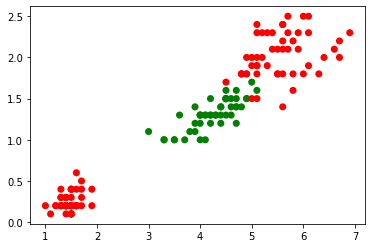

In [ ]:
# suivant la classe, les points affichés sont rouges ou verts (green)
cmp = np.array(['r','g'])
# importer les fonctions d'affichage 2D
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(data[:,2],data[:,3],c=cmp[target],s=50,edgecolors='none')
plt.show()

Le résultat (qui devrait correspondre à la figure suivante) montre que le problème de séparation visé n’est pas trivial si on se limite aux deux premières variables explicatives.

<img src="_images/versicolorVsAutresPetales.png" alt="Affichage des données en 2D" style="width:45%;">

## Question :

Affichez en 3D les observations en vous limitant aux **3** dernières variables explicatives.

## Perceptrons multi-couches (PMC) dans Scikit-learn

Dans Scikit-learn, les PMC sont implémentés dans les classes [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) pour la classification et [MPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) pour la régression. Nous examinons dans la suite l’utilisation des PMC pour traiter des problèmes de classification.

Les paramètres de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) permettent de définir l’architecture du PMC (nombre de couches et de neurones dans chaque couche), les fonctions d’activation pour la(les) couche(s) cachée(s), la méthode d’optimisation (L-BFGS, SGD ou Adam avec leurs hyper-paramètres), les méthodes de régularisation (que nous examinerons dans une séance de TP ultérieure), etc.

Le nombre d’entrées est donné par le nombre de variables explicatives et dépend de leur représentation (une variable nominale sera représentée par un codage *one-hot* et donc aura autant d’entrées spécifiques qu’elle a de modalités). Le nombre de sorties est égal au **nombre de classes**, même si dans les données utilisées une seule variable représente la classe par une valeur numérique différente. La fonction d’erreur (*loss*) employée est [l’entropie croisée](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (*cross-entropy*, *log loss*, *logistic loss*).

### Ensembles d’apprentissage et de test

Séparons d’abord l’enseble des observations disponibles en données d’apprentissage et données de test. Pour pouvoir répéter les expérimentations, il est utile d’initialiser explicitement le générateur pseudo-aléatoire avec `np.random.seed(...)`. La fonction `train_test_split` sépare les données en deux ensembles distincts, *train* et *test*, suivant la proportion de données de *test* indiquée avec `test_size` ; la séparation est réalisée par échantillonnage aléatoire uniforme.

In [ ]:
np.random.seed(10) # initialiser le générateur pseudo-aléatoire pour pouvoir répéter l'expérience
from sklearn.model_selection import train_test_split
# X : var. explicatives, y : var. expliquée, train : apprentissage, test : test
X_train1, X_test1, y_train1, y_test1 = train_test_split(data, target, test_size=0.4)

### Construction d’un modèle pour illustration

Afin de pouvoir visualiser la frontière nonlinéaire de séparation entre classes, nous construisons d’abord un modèle avec des valeurs par défaut pour tous les hyper-paramètres sauf pour le nombre maximum d’itérations et l’optimiseur (la valeur par défaut de 200 étant insuffisante pour la méthode d’optimisation SGD - descente de gradient stochastique) en utilisant les deux premières variables explicatives. Noter que la fonction d’activation par défaut pour les neurones de la couche cachée est ReLU. Vous pouvez examiner [les valeurs par défaut des autres paramètres](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [ ]:
from sklearn.neural_network import MLPClassifier
# donner une valeur à random_state rend possible la répétabilité
clf = MLPClassifier(solver='sgd', learning_rate_init=0.01, max_iter=10000, random_state=0)
# apprentissage avec les deux premières variables
clf.fit(X_train1[:,2:4], y_train1)

MLPClassifier(learning_rate_init=0.01, max_iter=10000, random_state=0,
              solver='sgd')

Les taux de bon classement en apprentissage (*train*) et en test sont :

In [ ]:
train_score = clf.score(X_train1[:,2:4], y_train1)
print("Le score en train est {}".format(train_score))
test_score = clf.score(X_test1[:,2:4], y_test1)
print("Le score en test est {}".format(test_score))

Le score en train est 0.9444444444444444
Le score en test est 0.9666666666666667


Nous affichons les résultats : observations d’apprentissage (points pleins), observations de test (points creux), frontière de séparation. Pour déterminer la frontière de séparation, nous définissons dans le domaine de variation des deux variables explicatives une grille dense, calculons les prédictions du modèle sur tous les points de la grille et affichons un contour qui correspond aux points du plan où l’indétermination est maximale.

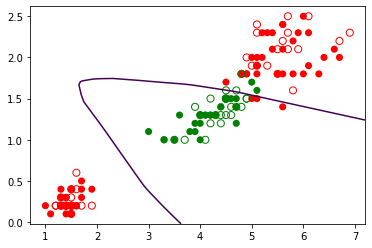

In [ ]:
# créer une nouvelle figure
plt.figure()
# afficher les nuages de points d'apprentissage (pleins) et de test (creux)
plt.scatter(X_train1[:,2],X_train1[:,3],c=cmp[y_train1],s=50,edgecolors='none')
plt.scatter(X_test1[:,2],X_test1[:,3],c='none',s=50,edgecolors=cmp[y_test1])
# calculer la probabilité de sortie du MLP pour tous les points du plan
nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z[:, 1].reshape(xx.shape)
# dessiner le contour correspondant à la frontière proba = 0,5
plt.contour(xx, yy, Z1, [0.5])
plt.show()

Le résultat (qui devrait correspondre à la figure suivante) montre la séparation trouvée.

<img src="_images/mlpVersicolor1000iter.png" alt="Résultat MLP sur Versicolor sépales, paramètres par défaut sauf max_iter=1000" style="width:45%;">

  
Nous avons employé la fonction `predict_proba` afin d’obtenir, pour chaque point de la grille définie par `xx, yy`, la prédiction du réseau sous la forme de probabilité. Le réseau a deux neurones de sortie, un donne la probabilité d’appartenance à la classe **Versicolor** et l’autre neurone la probabilité d’appartenance à l’autre classe. Avec `Z.shape` il est possible de vérifier que pour chaque observation il y a bien deux probabilités.

### Question :

Vérifiez que la somme des éléments de chaque ligne de Z est égale à 1 (la condition de normalisation est vérifiée).

Il est possible de visualiser les probabilités d’affectation à chaque classe comme des surfaces en 3 dimensions (le plan XY est celui des variables explicatives, l’axe Z correspond aux probabilités d’appartenance). Pour que la figure soit plus claire, nous ajoutons les observations avec `scatter` mais à mi-hauteur (plutôt que dans le plan Z=0).

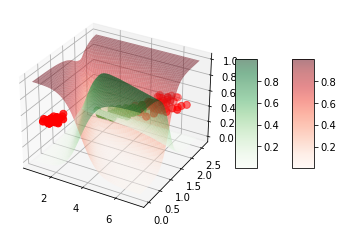

In [ ]:
from matplotlib import cm
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X_train1[:,2],X_train1[:,3],0.5,c=cmp[y_train1],s=50)
ax.scatter(X_test1[:,2],X_test1[:,3],0.5,c=cmp[y_test1],s=50)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z0 = Z[:, 0].reshape(xx.shape)
Z1 = Z[:, 1].reshape(xx.shape)
# probabilité d'appartenance à la classe Versicolor
surf1=ax.plot_surface(xx, yy, Z0, alpha=0.5, cmap=cm.Reds)
# probabilité d'appartenance à une autre classe
surf2=ax.plot_surface(xx, yy, Z1, alpha=0.5, cmap=cm.Greens)
plt.colorbar(surf1, shrink=0.5, aspect=5)
plt.colorbar(surf2, shrink=0.5, aspect=5)
plt.show()

Le résultat devrait correspondre à la figure suivante (en exécutant le programme avec python vous obtenez une figure que vous pouvez tourner pour mieux voir).

<img src="_images/mlpVersicolor1000iter3d.png" alt="Résultat MLP sur Versicolor sépales, paramètres par défaut sauf max_iter=1000" style="width:45%;">

### Question :

Quelle colonne de Z correspond à la probabilité d’appartenance à la classe **Versicolor** ?

Il est également possible de visualiser l’évolution de l’erreur d’apprentissage au fil des itérations car les valeurs sont conservées dans l’attribut `loss_curve_` du modèle obtenu :

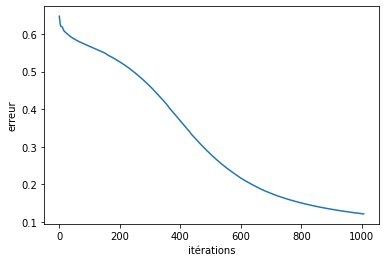

In [ ]:
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

<img src="_images/mlpVersicolor1000iterLossCurve.png" alt="Courbe de l'erreur d'apprentissage pour MLP sur Versicolor sépales, paramètres par défaut sauf max_iter=1000" style="width:45%;">

  
On constate qu’après 1000 itérations la pente de la courbe n’est pas nulle, il est donc possible de diminuer encore l’erreur d’apprentissage en augmentant le nombre d’itérations.

## Exploration : fonctions d’activation, nombre couches, nombre neurones par couche

Pour mieux comprendre l’utilisation des différentes fonctions d’activations proposées pour les neurones de la (des) couche(s) cachée(s), faisons des essais avec toutes les fonctions proposées, `identity`, `logistic`, `tanh`, `relu` (déjà employée ci-dessus), en conservant les autres paramètres (sauf `max_iter=1000`) aux valeurs par défaut. Remarquons que cela change le solveur utilisé, l’algorithme par défaut pour l’optimisation étant *Adam* (une variante adaptative de la descente de gradient).

In [ ]:
# identity :
clflinear = MLPClassifier(activation='identity', max_iter=1000, random_state=100)
clflinear.fit(X_train1[:,2:4], y_train1)
train_score = clflinear.score(X_train1[:,2:4], y_train1)
print("Le score en train avec identity est {}".format(train_score))
test_score = clflinear.score(X_test1[:,2:4], y_test1)
print("Le score en test avec identity est {}".format(test_score))
#
# logistic :
clfsigmoid = MLPClassifier(activation='logistic', max_iter=1000, random_state=100)
clfsigmoid.fit(X_train1[:,2:4], y_train1)
train_score = clfsigmoid.score(X_train1[:,2:4], y_train1)
print("Le score en train avec logistic est {}".format(train_score))
test_score = clfsigmoid.score(X_test1[:,2:4], y_test1)
print("Le score en test avec logistic est {}".format(test_score))
#
# tangente hyperbolique :
clftanh = MLPClassifier(activation='tanh', max_iter=1000, random_state=100)
clftanh.fit(X_train1[:,2:4], y_train1)
train_score = clftanh.score(X_train1[:,2:4], y_train1)
print("Le score en train avec tanh est {}".format(train_score))
test_score = clftanh.score(X_test1[:,2:4], y_test1)
print("Le score en test avec tanh est {}".format(test_score))

Le score en train avec identity est 0.7111111111111111
Le score en test avec identity est 0.6


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Le score en train avec logistic est 0.9444444444444444
Le score en test avec logistic est 0.9666666666666667
Le score en train avec tanh est 0.9444444444444444
Le score en test avec tanh est 0.9666666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Question :

Que constatez-vous ? Pourquoi les performances obtenues avec `identity` sont nettement inférieures ? Il est utile pour cela de regarder quelle frontière de séparation est trouvée.

## Question :

Avec la fonction d’activation ReLU pour les neurones de la couche cachée, faites varier le nombre de neurones de cette couche entre 2 et 200. Que constatez-vous ? Il peut être nécessaire d’augmenter la valeur de `max_iter` pour laisser l’apprentissage se poursuivre jusqu’à un minimum de l’erreur.

## Question :

Avec la fonction d’activation ReLU pour les neurones des couches cachées et en conservant 10 neurones par couche cachée, faites varier le nombre de couches cachées entre 2 et 5. Que constatez-vous ? Il peut être nécessaire d’augmenter la valeur de `max_iter` pour laisser l’apprentissage se poursuivre jusqu’à un minimum de l’erreur.